In [1]:
import nibabel as nib
import numpy as np

### What is in the header?

They seem to explain all the values in great depth here:
https://nifti.nimh.nih.gov/pub/dist/src/niftilib/nifti1.h

In [2]:
image = nib.load("80yearold_bet.nii")
hd = image.header

FileNotFoundError: No such file or no access: '80yearold_bet.nii'

In [3]:
print(hd)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 166   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.9441619  0.94214064 1.2047185  1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.2:a4f562d9'
aux_file        : b'none'
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.70710677
quatern_c       : -1.6473164e-10
quatern_d       : -0.70710677
qoffset_x     

### Table with all info in header:

### Orientations and transforming images to canonical orientation

In [4]:
nib.aff2axcodes(image.affine)

('I', 'P', 'L')

In [5]:
canonical_image = nib.as_closest_canonical(image)
nib.aff2axcodes(canonical_image.affine)
# RAS is how our GUI assumes things are aligned.

('R', 'A', 'S')

In [6]:
print("Before alignment: ",image.get_fdata().shape)
print("After alignment:  ",canonical_image.get_fdata().shape)

Before alignment:  (256, 256, 166)
After alignment:   (166, 256, 256)


### Voxel sizes

Size of each voxel can be calculated using the get_zooms() function

In [10]:
hd.get_zooms()

(0.9441619, 0.94214064, 1.2047185)

What about units?

I found the table below here: https://nifti.nimh.nih.gov/nifti-1/documentation/nifti1fields/nifti1fields_pages/xyzt_units.html

In [11]:
#define NIFTI_UNITS_UNKNOWN 0 /! NIFTI code for unspecified units. /
#                              / Space codes are multiples of 1. /
#define NIFTI_UNITS_METER   1 /! NIFTI code for meters. /
#define NIFTI_UNITS_MM      2 /! NIFTI code for millimeters. /
#define NIFTI_UNITS_MICRON  3 /! NIFTI code for micrometers. /


#                               / Time codes are multiples of 8. /
#define NIFTI_UNITS_SEC     8 /! NIFTI code for seconds. /
#define NIFTI_UNITS_MSEC   16 /! NIFTI code for milliseconds. /
#define NIFTI_UNITS_USEC   24 /! NIFTI code for microseconds. /


#                              /* These units are for spectral data: /
#define NIFTI_UNITS_HZ     32 /! NIFTI code for Hertz. /
#define NIFTI_UNITS_PPM    40 /! NIFTI code for ppm. /
#define NIFTI_UNITS_RADS   48 /! NIFTI code for radians per second. */

In [12]:
print(hd["xyzt_units"] & 0x07)
print(hd["xyzt_units"] & 0x38)

2
8


Therfore in seconds (doesn't matter) and milimeters

### Standard space 
Attaching continuos coordinates to voxels: https://nifti.nimh.nih.gov/nifti-1/documentation/nifti1fields/nifti1fields_pages/qsform.html

In [22]:
#define NIFTI_XFORM_UNKNOWN      0 /! Arbitrary coordinates (Method 1). /

#define NIFTI_XFORM_SCANNER_ANAT 1 /! Scanner-based anatomical coordinates /

#define NIFTI_XFORM_ALIGNED_ANAT 2 /! Coordinates aligned to another file's, or to anatomical "truth".            /

#define NIFTI_XFORM_TALAIRACH    3 /! Coordinates aligned to Talairach-Tournoux Atlas; (0,0,0)=AC, etc. /

#define NIFTI_XFORM_MNI_152      4 /! MNI 152 normalized coordinates. /

In [23]:
print(hd["qform_code"])
print(hd["sform_code"])

1
0


When you do print(header) it already tells you you are using scanner coordinates. As qform > 0 and sform is not bigger than 0. That means we are using method 2, which uses the following transformation to express space (x,y,z) in voxels (i,j,k)

     [ x ]   [ R11 R12 R13 ] [pixdim[1] * i ] + [ qoffset_x ]
     [ y ] = [ R21 R22 R23 ] [pixdim[2] * j ] + [ qoffset_y ]
     [ z ]   [ R31 R32 R33 ] [pixdim[3] * k ] + [ qoffset_z ]
     
As not sform > 0, all srow fields in the header are not used

### Magic and intent_name

intent_name provides 15 characters to specify a filename

If the magic field is "n+1", then the voxel data is stored in the same file as the header. In this case, the voxel data starts at offset (int)vox_offset into the header file. Thus, vox_offset=352.0 means that the data starts immediately after the NIFTI-1 header. If vox_offset is greater than 352, the NIFTI-1 format does not say much about the contents of the dataset file between the end of the header and the start of the data.

If the magic field is "ni1", then the voxel data is stored in the associated ".img" file, starting at offset 0 (i.e., vox_offset is not used in this case, and should be set to 0.0).


In [3]:
import matplotlib.pyplot as plt

(array([9.595796e+06, 1.790200e+05, 7.692700e+04, 4.033900e+04,
        1.345000e+03, 2.796900e+04, 2.397900e+04, 2.126800e+04,
        2.010500e+04, 8.290000e+02, 1.902700e+04, 1.899700e+04,
        1.924700e+04, 1.950300e+04, 5.390000e+02, 1.987100e+04,
        1.980900e+04, 1.962500e+04, 1.949200e+04, 4.020000e+02,
        1.919600e+04, 1.925200e+04, 1.933100e+04, 1.941800e+04,
        3.600000e+02, 1.931100e+04, 1.936800e+04, 1.983100e+04,
        3.640000e+02, 2.017400e+04, 2.038400e+04, 2.057100e+04,
        2.098600e+04, 3.150000e+02, 2.058900e+04, 2.103200e+04,
        2.079200e+04, 2.102400e+04, 2.440000e+02, 2.062400e+04,
        2.028300e+04, 2.050000e+04, 2.041300e+04, 2.700000e+02,
        2.071200e+04, 2.075100e+04, 2.039900e+04, 2.042200e+04,
        2.300000e+02, 2.064300e+04, 2.084600e+04, 2.094000e+04,
        2.118400e+04, 1.750000e+02, 2.102500e+04, 2.109500e+04,
        2.139800e+04, 2.290000e+02, 2.135800e+04, 2.179700e+04,
        2.174400e+04, 2.247700e+04, 2.14

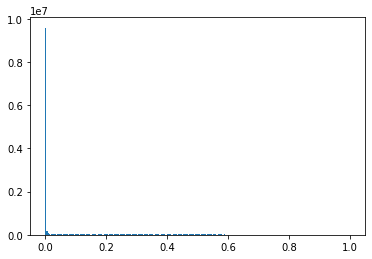

In [13]:
a = nib.load("/home/sabs-r3/Desktop/Paint4Brains/Paint4Brains/segmented.nii").get_fdata()
a = a / np.max(a)
plt.hist(a.flatten(), bins =256, range = (0,1))